# Ejercicios Entrega 3
##### Crea una aplicación sencilla de reconocimiento de imágenes. Debe admitir (al menos) dos argumentos:

##### `--models=<directorio>`, la carpeta donde hemos guardado un conjunto de imágenes de objetos o escenas que queremos reconocer.

##### `--method=<nombre>`, el nombre de un método de comparación. 

##### Cada fotograma de entrada se compara con los modelos utilizando el método seleccionado y se muestra información sobre el resultado (el modelo más parecido o probable, las distancias a los diferentes modelos, alguna medida de confianza, etc.).

Para el desarrollo de esta práctica, he realizado 4 ficheros distintos. 

En primer lugar un `./main.py` que es el que carga todas las imágenes que le pasan como parámetro, y el método de comparación de éstas. 

Por otro lado, he hecho 3 ficheros (`./mp_embedder.py`, `./histograma.py` y `./movimientoManos.py`) los cuales implementan distintos métodos de comparación de imágenes, dependiendo de como las comparen o con qué las comparen. Además, se utiliza el fichero `embedder.tflite` para inicializar las opciones del embedder de `mediapipe`.

Tras esta breve introducción, comentaré los ejercicios de esta entrega uno a uno.

## Ejercicio 1
### Diseña la aplicación para que sea cómodo añadir nuevos métodos. Cada método debe implementarse en un módulo diferente con un interfaz común.

Como he comentado en la introducción, la aplicacion consta de un `./main.py` y 3 métodos distintos de comparación de imágenes. 

Estos modelos siguen una interfaz común la cual les permite ser reconocidos por dicho `./main.py` como un método. Esta interfaz consta de tener una función `precompute()` y una función `compare()` en el fichero `.py`. Dichas funciones serán explicadas en los ejercicios 3, 4 y 5 de esta práctica.

De esta manera, es muy sencillo añadir nuevos métodos para comparar imágenes, ya que con esta interfaz, solamente necesitas pasar el nombre como parámetro a la hora de ejecutar la aplicación `./main.py` y la aplicación se encarga de reconocer que es un método válido para comparar.

Por último, explicaré como hay que ejecutar la aplicación en la linea de comandos:

`--models=<directorio>`, la carpeta donde hemos guardado un conjunto de imágenes de objetos o escenas que queremos reconocer. En mi caso será la carpeta de imágenes de la asignatura.

`--method=<nombre>`, el nombre de un método de comparación. Este no debe incluir la extensión `.py` del fichero, solamente el nombre

La aplicación se ha de ejecutar desde el directorio `Entrega3/src/` de la siguiente manera:

`python main.py --models=../../../images --method=mp_embedder --save` 

La ruta `../../../images` se debe a que mis archivos se distribuyen de la siguiente manera:

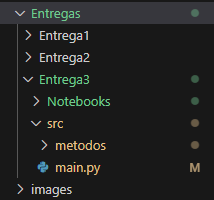

## Ejercicio 2
### Puedes permitir que se añadan modelos sobre la marcha y dar la opción de salvarlos.

Presionando la tecla `'s'` mientras se está ejecutando el programa, entramos en una nueva ventana para guardar un nuevo modelo a comparar. Esta ventana guardará el modelo cuando se presione la tecla `'Enter'`. 

Como se aprecia en la primera imagen, la similitud es de un 25%, lo cual quiere decir que no tiene similitud prácticamente con ningun modelo.

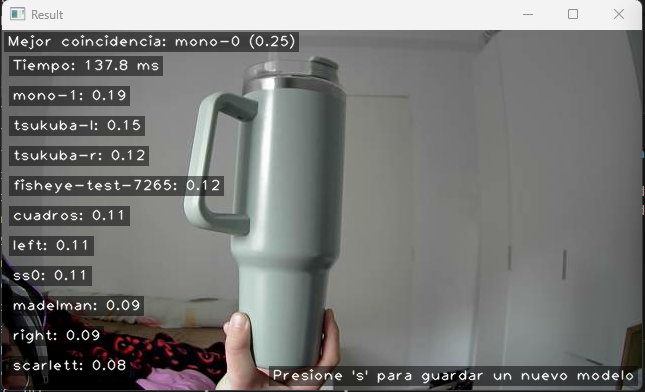

En esta imagen se puede ver la ventana de comparación junto a la ventana de guardar el nuevo modelo a comparar.

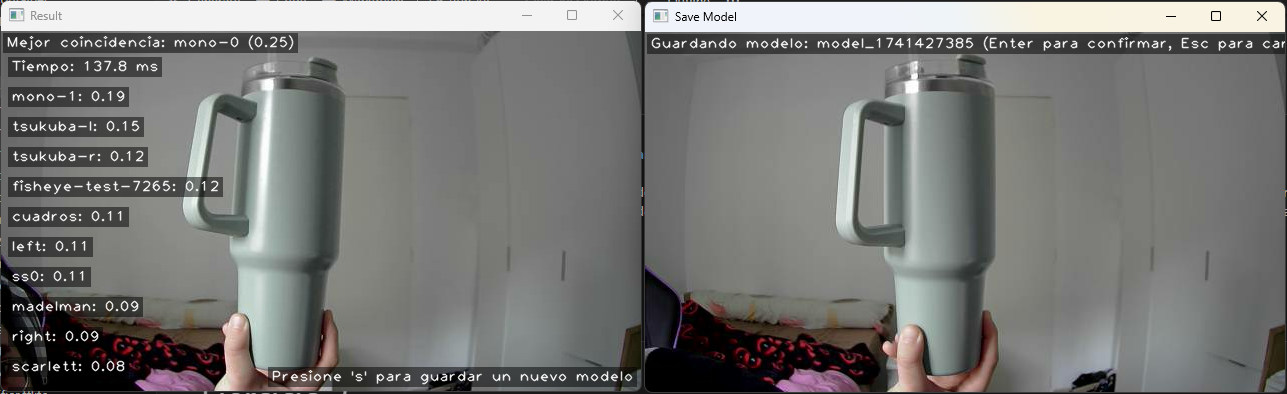

Tras guardar el nuevo modelo, apreciamos que tiene una similitud del 74%, respecto a la imagen guardada con el comando `'s + 'Enter'`. El no tener el cerca del 100% de similitud se debe a que el modelo mp_embedder de mediapipe realmente está limitado y no es todo lo eficaz que se querría, aunque es una buena aproximación.

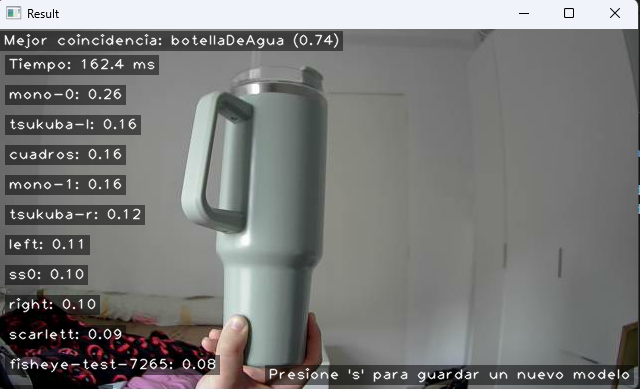

## Ejercicio 3
### Precomputa todo lo necesario para cada modelo, para que la comparación sea lo más rápida posible.

Como se mencionó al inicio, cada método cuenta con la función `precompute()`, la cual toma como parámetro una imagen y la modifica según las necesidades de cada método.

En el caso de `./histograma.py`, le cambia el color a HSV para realizar una comparación por colores, tras ello calcula el histograma y lo normaliza. 

In [ ]:
def precompute(image):
    """Precomputa el histograma de la imagen"""
    # Convertir a HSV para mejor comparación de colores
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Calcular histograma
    hist = cv2.calcHist([hsv], [0, 1], None, [180, 256], [0, 180, 0, 256])
    # Normalizar histograma
    cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)
    return hist

En el caso de `./mp_embedder.py`, pasa la imagen a RGB, para poder crear la imagen de MediaPipe. A raíz de esa imagen, genera el embedding y devuelve el vector proporcionado por ese embedding.

In [ ]:
def precompute(image):
    """Precomputa el embedding de la imagen usando MediaPipe"""
    # Convertir a formato RGB (MediaPipe usa RGB)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Crear objeto de imagen de MediaPipe
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_image)
    # Obtener embedding
    embedding_result = embedder.embed(mp_image)
    # Devolver el vector de embedding
    return embedding_result.embeddings[0].embedding

En el caso de `./movimientoManos.py`, también comvierte la imagen a RGB, pero en este caso lo hace para llamar a la función process del detector de manos de MediaPipe. En el caso de no tener resultados, se devuelve `None`, y en caso contrario, se obtienen las coordenadas de los puntos clave, se centran y escalan dichos puntos, y se retornan como respuesta de la función.

In [ ]:
hands = mp.solutions.hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)
def precompute(image):
    """Extrae los puntos clave de la mano en la imagen modelo"""
    # Convertir a RGB para MediaPipe
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Detectar manos
    results = hands.process(rgb_image)
    
    if results.multi_hand_landmarks:
        # Extraer coordenadas de los puntos clave
        landmarks = results.multi_hand_landmarks[0].landmark
        points = np.array([(lm.x, lm.y) for lm in landmarks])
        
        # Normalizar puntos (centrar y escalar)
        centroid = np.mean(points, axis=0)
        points -= centroid
        scale = np.sqrt(np.sum(np.square(points)) / len(points))
        points /= scale
        
        return points
    return None

Por último, estos métodos son llamados desde el fichero `./main.py` en 2 secciones distintas.

La primera es cuando cargamos todas las imágenes a comparar, para lógicamente ahorrar tiempo de procesamiento, ya que una vez obtenidos los modelos a comparar, ya no deberían de volver a ser calculados. Esto se hace para optimización de tiempo de ejecución.

Esto se ve reflejado en el siguiente bloque de código:

In [ ]:
# Crear directorio de modelos si no existe
if not os.path.exists(args.models):
    os.makedirs(args.models)

# Cargar modelos (imagenes) desde el directorio
models = {}
for filename in os.listdir(args.models):
    if filename.endswith((".jpg", ".png", ".jpeg")):
        model_path = os.path.join(args.models, filename)
        model_name = os.path.splitext(filename)[0]
        model_img = cv2.imread(model_path)
        if model_img is not None:
            # Precomputar características para el modelo
            models[model_name] = {
                'image': model_img,
                'features': comparison_methods[args.method].precompute(model_img)
            }
            print(f"Modelo cargado: {model_name}")

La segunda es cuando se guarda una nueva imagen con la opción `'s + 'Enter'`. En este caso, solo precomputa para la nueva imagen y no para todas las imágenes de la carpeta de modelos.

In [ ]:
if save_mode:
    putText(frame, f"Guardando modelo: {new_model_name} (Enter para confirmar, Esc para cancelar)")
    cv2.imshow('Save Model', frame)
    
    if key == 13:  # Enter
        model_path = os.path.join(args.models, f"{new_model_name}.jpg")
        cv2.imwrite(model_path, frame)
        models[new_model_name] = {
            'image': frame.copy(),
            'features': comparison_methods[args.method].precompute(frame)
        }
        print(f"Nuevo modelo guardado: {new_model_name}")
        save_mode = False

## Ejercicio 4
### Implementa un método basado en el "embedding" obtenido por [mediapipe](https://developers.google.com/mediapipe/solutions/vision/image_embedder) (`code/DL/embbeder`).

En primer lugar explicaré el codigo del fichero `mp_embedder.py`. En este fichero se establecen el directorio actual y la ruta del fichero `embedder.tflite`, para luego leerlo y crear las opciones del embedder a raíz de él. Con esas opciones, se crea el embedder propiamente dicho para poder hacer el precomputado de los modelos explicado anteriormente. 

Por último, la función `compare()` utiliza el metodo precompute para obtener el vector de embedding del frame actual, y calcula la similitud con uno de los modelos precomputados (uno a la vez para obtener todas las similitudes a partir de un bucle en el fichero `./main.py`) a raíz del producto matricial y la magnitud de ambos vectores.


In [ ]:
import cv2
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import os

from mediapipe.tasks.python.core.base_options import BaseOptions

# Obtener la ruta absoluta al directorio actual (methods)
current_dir = os.path.dirname(os.path.abspath(__file__))

# Ruta al modelo TFLite que está en el mismo directorio
model_path = os.path.join(current_dir, 'embedder.tflite')

# Verificar que el archivo existe
if not os.path.exists(model_path):
    raise FileNotFoundError(f"No se encontró el modelo en: {model_path}")
    
print(f"Usando modelo desde: {model_path}")  # Para depurar

# Leer el contenido del archivo
with open(model_path, 'rb') as f:
    model_content = f.read()

# Inicializar el embedder de MediaPipe usando el modelo
base_options = BaseOptions(model_asset_buffer=model_content)
options = vision.ImageEmbedderOptions(base_options=base_options)

embedder = vision.ImageEmbedder.create_from_options(options)

def precompute(image):
    """Precomputa el embedding de la imagen usando MediaPipe"""
    # Convertir a formato RGB (MediaPipe usa RGB)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Crear objeto de imagen de MediaPipe
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_image)
    # Obtener embedding
    embedding_result = embedder.embed(mp_image)
    # Devolver el vector de embedding
    return embedding_result.embeddings[0].embedding

def compare(image, model_features):
    """Compara la imagen con el modelo usando embeddings de MediaPipe"""
    # Reutilizo el metodo precompute para obtener el embedding de la imagen
    image_embedding = precompute(image)
    
    # Calcular similitud de coseno
    dot_product = np.dot(model_features, image_embedding) #Producto matricial estandar (multiplicacion de matrices) 
    norm_model, norm_image = np.linalg.norm(model_features), np.linalg.norm(image_embedding)
    similarity = dot_product / (norm_model * norm_image)
    
    return similarity

Como se comprueba en la imagen, al no tener un modelo guardado con similitud a esa botella, la mayor similitud que encuentra es de un 25%. Además se ve como el tiempo de comparación es bastante alto (unos 140ms).

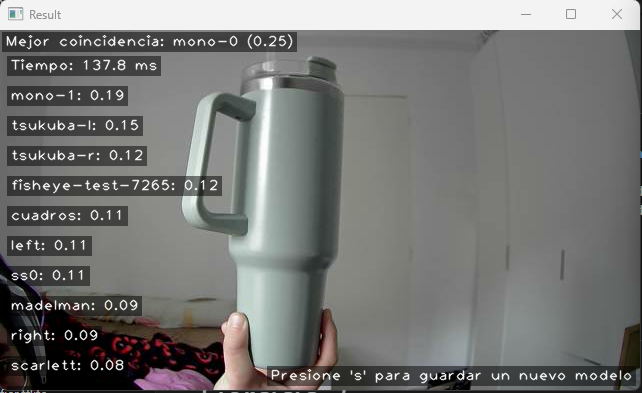

También he hecho otro método de comparación, el `./histograma.py`, el cual realiza una comparación por colores a partir del histograma de colores de cada imagen.

In [ ]:
import cv2
import numpy as np

def precompute(image):
    """Precomputa el histograma de la imagen"""
    # Convertir a HSV para mejor comparación de colores
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Calcular histograma
    hist = cv2.calcHist([hsv], [0, 1], None, [180, 256], [0, 180, 0, 256])
    # Normalizar histograma
    cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)
    return hist

def compare(image, model_features):
    """Compara la imagen con el modelo usando histogramas"""
    #Reutilizo el metodo precompute para obtener el histograma de la imagen normalizado
    hist=precompute(image)
    # Comparar histogramas (mayor valor = mayor similitud)
    similarity = cv2.compareHist(model_features, hist, cv2.HISTCMP_CORREL)
    return similarity

Con este método se consigue un tiempo de comparación mucho menor (35ms). Sin embargo, al ser una comparación por colores, se demuestra que no es un método fiable ya que el frame de la botella realmente no tiene similitud con el resto de modelos realmente, aunque si que muestre una gran similitud de colores (98%), como se comprueba en la imagen.

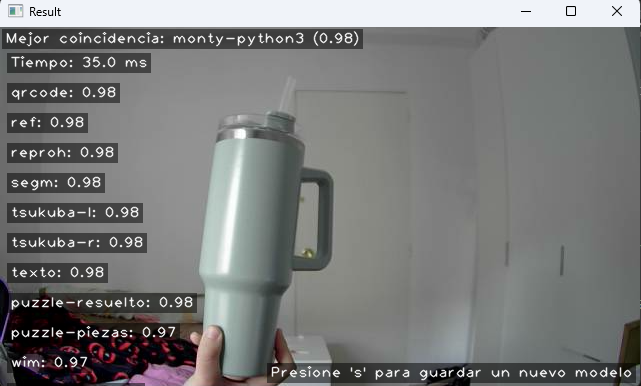

## Ejercicio 5
### Implementa un reconocedor de gestos de manos basado, por ejemplo, en la distancia procrustes.

El modelo `movimientoManos.py` intenta reconocer cuando hay manos en el frame actual.

El metodo de comparación es prácticamente idéntico a los anteriores. Se usa el precompute para obtener los puntos significativos de la imagen y se llama a la función `procrustes()` para realizar la comparación de ambos basado en la distancia procrustes.

In [ ]:
import cv2
import numpy as np
import mediapipe as mp

# Inicializar el detector de manos de MediaPipe
hands = mp.solutions.hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)

def compare(image, model_features):
    """Compara los gestos de manos usando distancia de Procrustes"""
    if model_features is None:
        return 0.0
    #Reutilizo el metodo precompute para obtener los puntos de la imagen normalizados y centrados
    points = precompute(image)
    if points is None:
        return 0.0
    
    # Calcular similitud
    similarity = procrustes_distance(points, model_features)
    
    return similarity

La funcion `procrustes()` toma como parámetros los puntos significativos de 2 imágenes. Se asegura de que esté centrados y normalizados y tras ello, obtiene la matriz de correlación de ambos conjuntos de puntos. 

Esta matriz se descompone en los valores 'u', 's' y 'v', donde:

* u es una matriz ortogonal de tamaño m x m(vectores singulares izquierdos).

* s es una matriz diagonal de tamaño m x n con los valores singulares de corr

* v es una matriz ortogonal de tamaño n x n(vectores singulares derechos).

Tras ello se calcula la matriz de rotación entre 'u' y 'v' y se le aplica al primer conjunto de puntos. Después se calcula la distancia euclídea entre el primer conjunto de puntos rotado y el segundo y con ella se calcula la similitud de las imágenes.

In [ ]:
def procrustes_distance(points1, points2):
    """Calcula la distancia de Procrustes entre dos conjuntos de puntos"""
    if points1 is None or points2 is None:
        return float('inf')
    
    # Asegurarse de que los puntos están centrados
    points1 = points1 - np.mean(points1, axis=0)
    points2 = points2 - np.mean(points2, axis=0)
    
    # Normalizar
    norm1 = np.sqrt(np.sum(points1 ** 2))
    norm2 = np.sqrt(np.sum(points2 ** 2))
    
    if norm1 == 0 or norm2 == 0:
        return float('inf')
    
    points1 /= norm1
    points2 /= norm2
    
    # Calcular matriz de correlación
    corr = np.dot(points1.T, points2)
    
    # Descomposición SVD (descomposición en valores singulares)
    u, s, v = np.linalg.svd(corr) 
    # u es una matriz ortogonal de tamaño m x m(vectores singulares izquierdos).
    # s es una matriz diagonal de tamaño m x n con los valores singulares de corr
    # v es una matriz ortogonal de tamaño n x n(vectores singulares derechos).
    
    # Calcular matriz de rotación
    r = np.dot(u, v)
    
    # Aplicar rotación
    points1_rotated = np.dot(points1, r)
    
    # Calcular distancia euclidea
    distance = np.sum(np.square(points1_rotated - points2))
    
    # Convertir a similitud (mayor = más similar)
    similarity = 1.0 / (1.0 + distance)
    
    return similarity


Como se ve en las imágenes, tengo 2 modelos guardados que contienen manos, uno llamado `palma.jpg` y otro llamado `dosDedos.jpg`

En la primera imagen, se ve como reconoce con más similitud el modelo de la palma y en la segunda el de los dos dedos

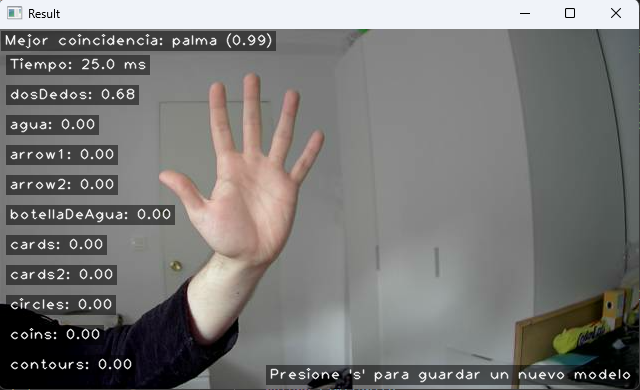 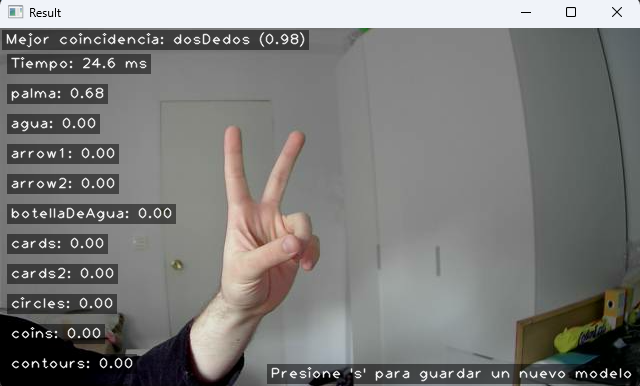


Sin embargo, si guardo un modelo el cual no tiene manos en la imagen, por mucho que el frame actual sea exactamente igual que el modelo que se acaba de guardar, no lo reconoce como similar puesto que no reconoce ninguna mano.

Podemos comprobar que el modelo ha sido guardado mirando en la parte inferior de la imagen, en la consola de comandos con el mensaje: "Nuevo modelo guardado: model_1741432012"

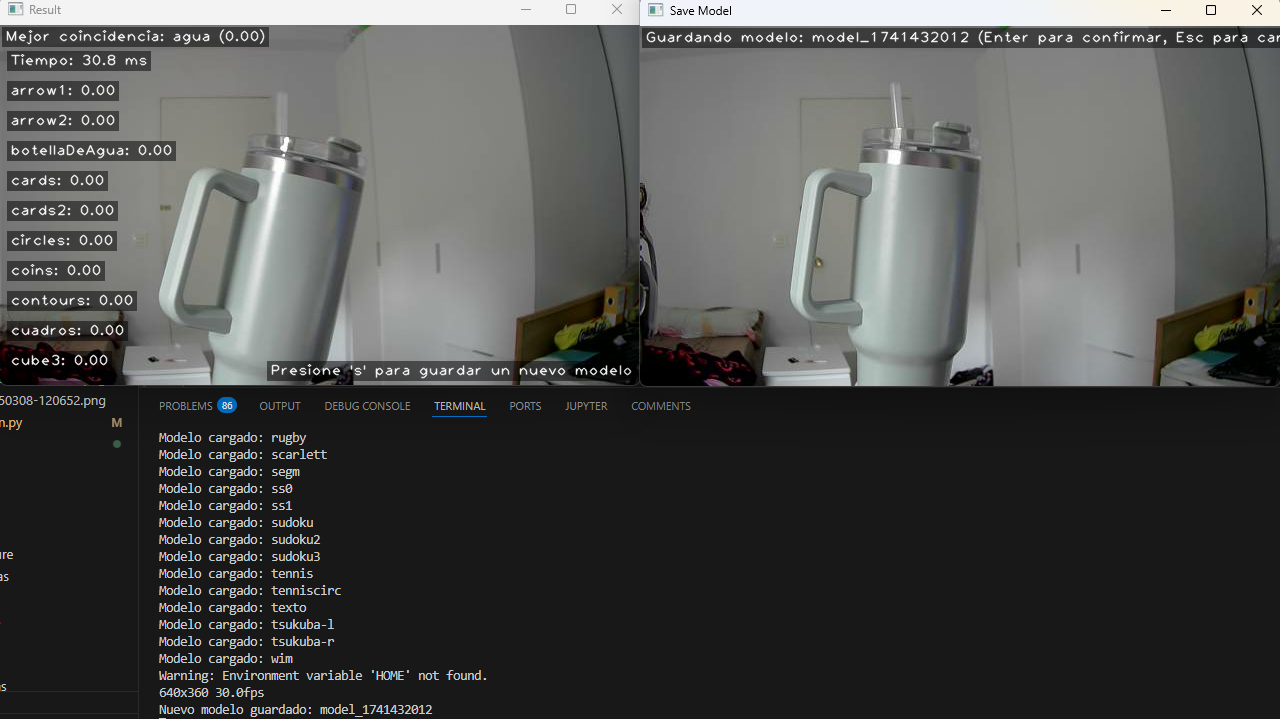